# S&P 500 Signal Classifier

Approach:
1. Create features
2. Winsorize data
3. Test, Train split data
4. Scale the test and train data
6. Original, Oversample, and Undersample the data
7. Apply RandomForestClassifier, XGBoost, and LightBoost to predict

## Install Required Packages

In [1]:
# Import tools required to verify if packages already exist
import subprocess
import sys

def check_install_packages(package_list):
    for package_name, install_command in package_list.items():
        try:
            __import__(package_name)
            print(f"'{package_name}' is already installed.")
        except ImportError:
            print(f"'{package_name}' is not installed. Installing now...")
            subprocess.check_call(install_command)
            print(f"'{package_name}' has been installed successfully.")

# List of packages to check and install if necessary
packages = {
    'yfinance': [sys.executable, "-m", "pip", "install", "yfinance", "--upgrade", "--no-cache-dir"],
    'sklearn': [sys.executable, "-m", "pip", "install", "scikit-learn"],
    'xgboost': [sys.executable, "-m", "pip", "install", "xgboost"],
    'lightgbm': [sys.executable, "-m", "pip", "install", "lightgbm"]
}

# Check and install the packages
check_install_packages(packages)

'yfinance' is already installed.
'sklearn' is already installed.
'xgboost' is already installed.
'lightgbm' is already installed.


In [2]:
# Install Yahoo Finance
# !pip install yfinance --upgrade --no-cache-dir

In [3]:
# Install SciKit Learn
# !pip install scikit-learn

In [4]:
# Install XGBoost
# !pip install xgboost

In [5]:
# Install LightBoost
# !pip install lightgbm

## Import Required Dependencies

In [6]:
# Import the required libraries and dependencies
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from helper_functions import rsi, print_classification_report, print_balanced_accuracy_report

In [7]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Retrieve and Load Data

In [8]:
# Retreive data
sp500 = yf.Ticker('^GSPC')
sp500 = sp500.history(period='max')

In [9]:
# Drop timezone from datetime
sp500 = sp500.reset_index()
sp500['Date'] = sp500['Date'].dt.tz_localize(None)
sp500.set_index('Date', inplace=True)

In [10]:
# Get the last rows of the DataFrame
sp500 = sp500.tail(24252) # Get max available data

In [11]:
# Display data
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-26,5460.709961,5483.140137,5451.870117,5477.899902,3563920000,0.0,0.0
2024-06-27,5473.589844,5490.810059,5467.540039,5482.870117,3589530000,0.0,0.0
2024-06-28,5488.479980,5523.640137,5451.120117,5460.479980,7199220000,0.0,0.0


In [12]:
# Create stock df
stock_df = pd.DataFrame(sp500).dropna()
stock_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-26,5460.709961,5483.140137,5451.870117,5477.899902,3563920000,0.0,0.0
2024-06-27,5473.589844,5490.810059,5467.540039,5482.870117,3589530000,0.0,0.0
2024-06-28,5488.479980,5523.640137,5451.120117,5460.479980,7199220000,0.0,0.0


In [13]:
# Drop columns
stock_df.drop(columns={'Volume', 'Dividends', 'Stock Splits'}, inplace=True)

# Sort by ascending date
stock_df = stock_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(stock_df.head())
display(stock_df.tail())

,Open,High,Low,Close
Date,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000
1928-01-03,17.760000,17.760000,17.760000,17.760000
1928-01-04,17.719999,17.719999,17.719999,17.719999
1928-01-05,17.549999,17.549999,17.549999,17.549999
1928-01-06,17.660000,17.660000,17.660000,17.660000


,Open,High,Low,Close
Date,,,,
2024-06-26,5460.709961,5483.140137,5451.870117,5477.899902
2024-06-27,5473.589844,5490.810059,5467.540039,5482.870117
2024-06-28,5488.479980,5523.640137,5451.120117,5460.479980
2024-07-01,5471.080078,5479.549805,5446.529785,5475.089844
2024-07-02,5461.839844,5509.689941,5458.430176,5509.009766


In [14]:
# Rename dataframe to data
data = stock_df

## Perform Feature Engineering

In [15]:
# Feature Engineering
# Moving Averages
data['SMA10'] = data['Close'].rolling(window=10).mean()
data['SMA20'] = data['Close'].rolling(window=20).mean()
data['SMA30'] = data['Close'].rolling(window=20).mean()
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA100'] = data['Close'].rolling(window=100).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()

data['RSI'] = rsi(data)

# MACD
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['SL'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
data['BollM'] = data['Close'].rolling(window=20).mean()
data['BollU'] = data['BollM'] + (2 * data['Close'].rolling(window=20).std())
data['BollL'] = data['BollM'] - (2 * data['Close'].rolling(window=20).std())

# Identify crossover signal for Target Column
# Close < Bollinger Mid and RSI < 50 and MACD < 0
data['Signal'] = np.where((data['Close'] < data['BollM']) & (data['RSI'] < 50) & (data['MACD'] < 0), 1, 0)

# Calculate return
data['Return'] = data['Close'].pct_change().shift(-1)  # Next day's return

# Label Data
# Buy ONLY if all Crossover conditions are met
# Assume profitable if return > 0%
data['Target'] = np.where((data['Signal'] > 0) & (data['Return'] > 0.0), 1, 0)

# Prepare dataset
features = ['SMA10', 'SMA20', 'SMA30', 'SMA50', 'SMA100', 'SMA200', 'RSI', 'MACD', 'SL', 'BollM', 'BollU', 'BollL']
dataset = data.dropna()[features + ['Target']]

## Perform Winsorization of Data

In [16]:
from scipy.stats.mstats import winsorize
dataset['SMA10'] = winsorize(np.array(dataset['SMA10']), limits=[.05, .05])
dataset['SMA20'] = winsorize(np.array(dataset['SMA20']), limits=[.05, .05])
dataset['SMA30'] = winsorize(np.array(dataset['SMA30']), limits=[.05, .05])
dataset['SMA50'] = winsorize(np.array(dataset['SMA50']), limits=[.05, .05])
dataset['SMA100'] = winsorize(np.array(dataset['SMA100']), limits=[.05, .05])
dataset['SMA200'] = winsorize(np.array(dataset['SMA200']), limits=[.05, .05])
dataset['MACD'] = winsorize(np.array(dataset['MACD']), limits=[.05, .05])
dataset['BollM'] = winsorize(np.array(dataset['BollM']), limits=[.05, .05])
dataset['BollU'] = winsorize(np.array(dataset['BollU']), limits=[.05, .05])
dataset['BollL'] = winsorize(np.array(dataset['BollL']), limits=[.05, .05])
dataset['SL'] = winsorize(np.array(dataset['SL']), limits=[.05, .05])

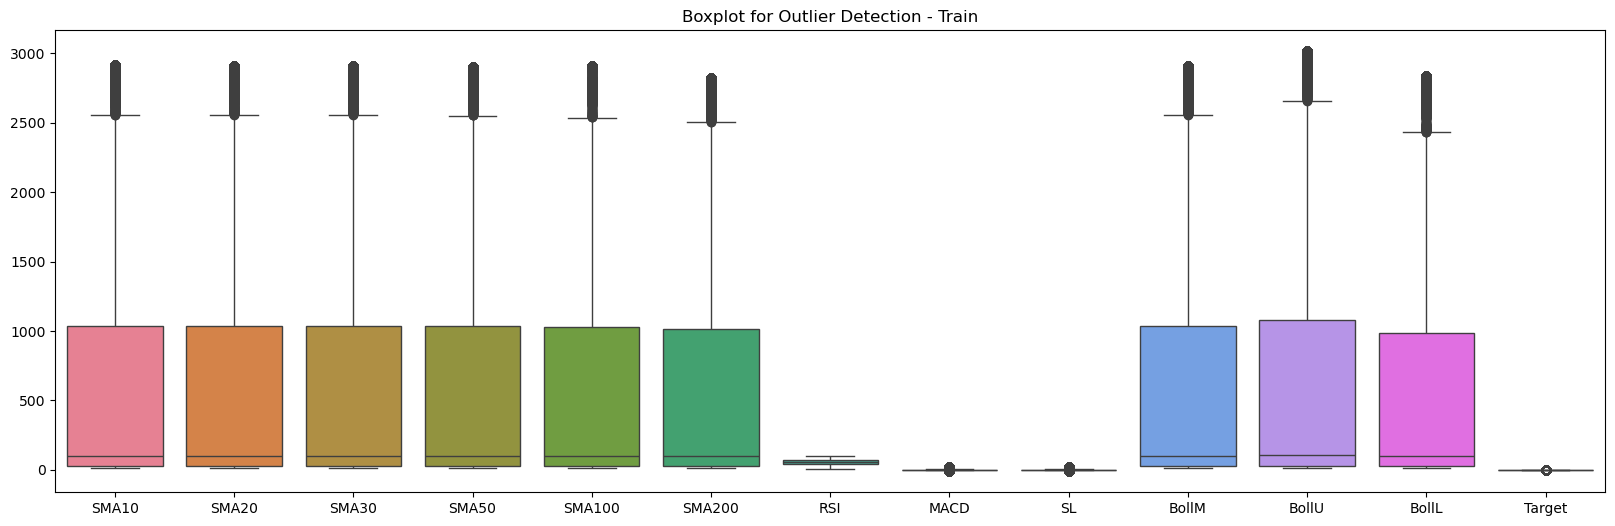

In [17]:
plt.figure(figsize=(20, 6))
sns.boxplot(dataset)
plt.title("Boxplot for Outlier Detection - Train")
plt.show()

## Perform Train and Test Splits

In [18]:
# Define train and test sets
X = dataset[features]
y = dataset['Target']

# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

# Split data
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [19]:
# Split data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Perform Scaling

In [20]:
# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames to maintain column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Perform Classifications

## Original Scaled Data with Untuned RandomForestClassifier

In [21]:
# Define the model
clf = RandomForestClassifier(random_state=1)

# Fit the model
clf.fit(X_train_scaled, y_train)

# Predict using the model
train_pred = clf.predict(X_train_scaled)
test_pred = clf.predict(X_test_scaled)

# Generate classification report
# Print scores
print_balanced_accuracy_report(y_train, y_test, train_pred, test_pred)

# Print classification reports
print_classification_report(y_test, test_pred)

Balanced Accuracy Scores
--------------------------------------------------------
1.0 training score
0.7824314388851115 testing score
0.2175685611148885 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3547
           1       0.56      0.63      0.59       459

    accuracy                           0.90      4006
   macro avg       0.76      0.78      0.77      4006
weighted avg       0.91      0.90      0.90      4006

--------------------------------------------------------


## Over Sampled Scaled Data with Untuned RandomForestClassifier

In [22]:
# Import RandomOverSampler from imblearn
from imblearn.over_sampling import RandomOverSampler

# Instantiate a RandomOversampler instance
ros = RandomOverSampler(random_state=1)

# Fit the training data to the `RandomOverSampler` model
X_oversampled, y_oversampled = ros.fit_resample(X_train_scaled, y_train)

# Count distinct values
y_oversampled.value_counts()

Target
0    17245
1    17245
Name: count, dtype: int64

In [23]:
# Instantiate the model
ros_clf = RandomForestClassifier(random_state=1)

# Fit the model
ros_clf.fit(X_oversampled, y_oversampled)

# Predict using the model
train_pred = ros_clf.predict(X_train_scaled)
test_pred = ros_clf.predict(X_test_scaled)

# Generate classification report
# Print scores
print_balanced_accuracy_report(y_train, y_test, train_pred, test_pred)

# Print classification reports
print_classification_report(y_test, test_pred)

Balanced Accuracy Scores
--------------------------------------------------------
0.9999710060887214 training score
0.591990961093268 testing score
0.4079800449954534 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3547
           1       0.50      0.21      0.30       459

    accuracy                           0.89      4006
   macro avg       0.70      0.59      0.62      4006
weighted avg       0.86      0.89      0.86      4006

--------------------------------------------------------


## Under Sampled Scaled Data with Untuned RandomForestClassifier

In [24]:
# Import RandomUnderSampler from imblearn
from imblearn.under_sampling import RandomUnderSampler

# Instantiate a RandomOversampler instance
rus = RandomUnderSampler(random_state=1)

# Fit the training data to the `RandomOverSampler` model
X_undersampled, y_undersampled = rus.fit_resample(X_train_scaled, y_train)

# Count distinct values
y_undersampled.value_counts()

Target
0    2790
1    2790
Name: count, dtype: int64

In [25]:
# Instantiate the model
rus_clf = RandomForestClassifier(random_state=1)

# Fit the model
rus_clf.fit(X_undersampled, y_undersampled)

# Predict using the model
train_pred = rus_clf.predict(X_train_scaled)
test_pred = rus_clf.predict(X_test_scaled)

# Generate classification report
# Print scores
print_balanced_accuracy_report(y_train, y_test, train_pred, test_pred)

# Print classification reports
print_classification_report(y_test, test_pred)

Balanced Accuracy Scores
--------------------------------------------------------
0.9237460133371992 training score
0.6807907262143651 testing score
0.2429552871228341 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3547
           1       0.51      0.41      0.46       459

    accuracy                           0.89      4006
   macro avg       0.72      0.68      0.70      4006
weighted avg       0.88      0.89      0.88      4006

--------------------------------------------------------


## Original Scaled Data and Untuned XGBoost Classifier

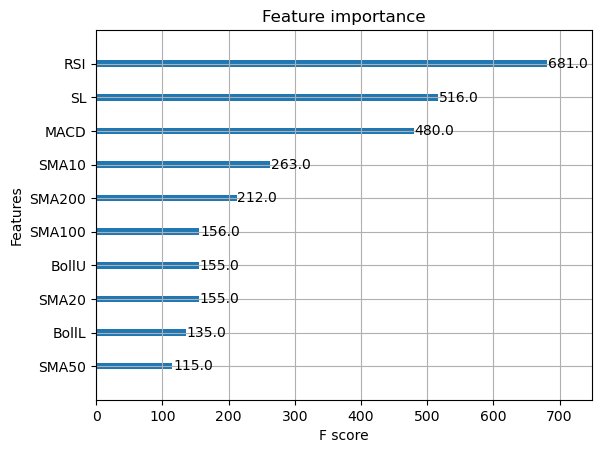

Balanced Accuracy Scores
--------------------------------------------------------
0.9023389460973053 training score
0.6910301319412582 testing score
0.2113088141560471 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3547
           1       0.57      0.42      0.49       459

    accuracy                           0.90      4006
   macro avg       0.75      0.69      0.72      4006
weighted avg       0.89      0.90      0.89      4006

--------------------------------------------------------


In [26]:
# Define the model
xgb_clf = XGBClassifier(random_state=1)

# Fit the model
xgb_clf.fit(X_train_scaled, y_train)

# Predict using the model
train_pred = xgb_clf.predict(X_train_scaled)
test_pred = xgb_clf.predict(X_test_scaled)

# Plot feature importance
from xgboost import plot_importance
plot_importance(xgb_clf)
plt.show()

# Generate classification report
# Print scores
print_balanced_accuracy_report(y_train, y_test, train_pred, test_pred)

# Print classification reports
print_classification_report(y_test, test_pred)

## Under Sampled Scaled Data and Untuned XGBoost Classifier

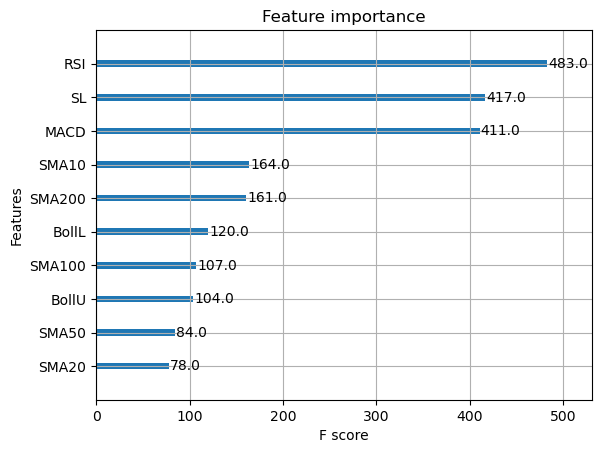

Balanced Accuracy Scores
--------------------------------------------------------
0.9169614380979993 training score
0.7956958932431162 testing score
0.1212655448548832 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3547
           1       0.53      0.67      0.59       459

    accuracy                           0.90      4006
   macro avg       0.74      0.80      0.77      4006
weighted avg       0.91      0.90      0.90      4006

--------------------------------------------------------


In [27]:
# Define the model
xgb_rus_clf = XGBClassifier(random_state=1)

# Fit the model
xgb_rus_clf.fit(X_undersampled, y_undersampled)

# Predict using the model
train_pred = xgb_rus_clf.predict(X_train_scaled)
test_pred = xgb_rus_clf.predict(X_test_scaled)

# Plot feature importance
plot_importance(xgb_rus_clf)
plt.show()

# Generate classification report
# Print scores
print_balanced_accuracy_report(y_train, y_test, train_pred, test_pred)

# Print classification reports
print_classification_report(y_test, test_pred)

## Under Sampled Scaled Data with XGBoost Parameter Tuning

In [28]:
# Try the following values for learning_rate
rate = np.arange(0.01, 1.0, 0.01)
models = {'train_score': [], 'test_score': [], 'learning_rate': []}

# Loop through each value in learning_rates
for r in rate:
    # Initialize the classifier with parameter variables
    xgb_rus_clf = XGBClassifier(learning_rate = r, tree_method='approx', random_state=1)

    # Fit the undersampled data the new model
    xgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = xgb_rus_clf.predict(X_train_scaled)
    test_pred = xgb_rus_clf.predict(X_test_scaled)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['learning_rate'].append(r)

# Create a dataframe from the models dictionary with learning_rate as the index
models_df = pd.DataFrame(models).set_index('learning_rate')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
learning_rate,,
0.02,0.905562,0.931850
0.04,0.905973,0.924981
0.03,0.905857,0.922905


In [29]:
# Sort the dataframe by test_score in descending order and get the top 3
top_learning_rates = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3 
top_learning_rates

[0.02, 0.04, 0.03]

<Axes: xlabel='learning_rate'>

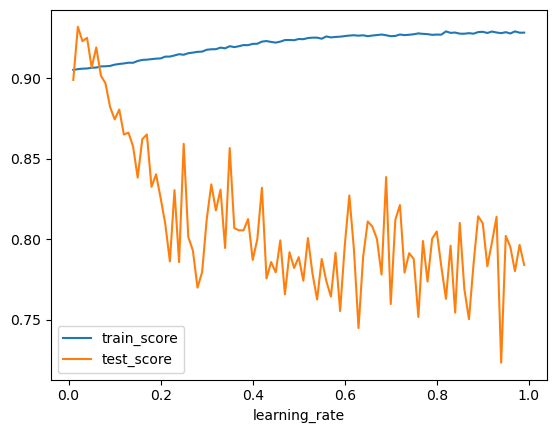

In [30]:
# Plot the results
models_df.plot()

In [31]:
# Try the following values for n_estimators
estimators = range(100, 200, 1)
models = {'train_score': [], 'test_score': [], 'n_estimators': []}

# Loop through each value in n_estimators
for n in estimators:
    # Initialize the classifier with parameter variables
    xgb_rus_clf = XGBClassifier(n_estimators = n, tree_method='approx', random_state=1)

    # Fit the undersampled data the new model
    xgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = xgb_rus_clf.predict(X_train_scaled)
    test_pred = xgb_rus_clf.predict(X_test_scaled)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['n_estimators'].append(n)

# Create a dataframe from the models dictionary with n_estimators as the index
models_df = pd.DataFrame(models).set_index('n_estimators')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
n_estimators,,
108,0.918730,0.820174
109,0.918643,0.819507
105,0.918116,0.817047


In [32]:
# Sort the dataframe by test_score in descending order and get the top 3
top_n_estimators = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3
top_n_estimators

[108, 109, 105]

<Axes: xlabel='n_estimators'>

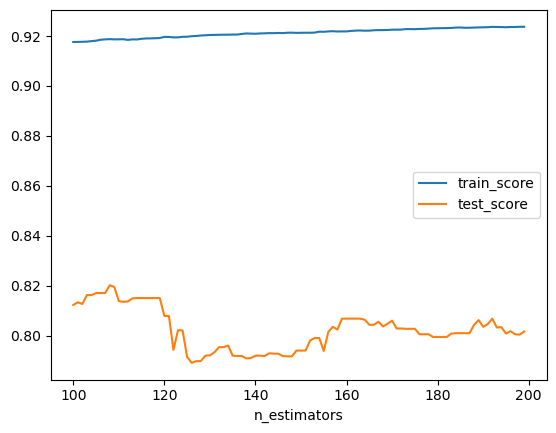

In [33]:
# Plot the results
models_df.plot()

In [34]:
# Try the following values for max_depth
max_depths = range(2, 30)
models = {'train_score': [], 'test_score': [], 'max_depth': []}

# Loop through each value in max_depths
for depth in max_depths:
    # Initialize the classifier with parameter variables
    xgb_rus_clf = XGBClassifier(max_depth = depth, tree_method='approx', random_state=1)
    
    # Fit the undersampled data the new model
    xgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = xgb_rus_clf.predict(X_train_scaled)
    test_pred = xgb_rus_clf.predict(X_test_scaled)

    # Caclulate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_depth'].append(depth)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_depth')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
max_depth,,
3,0.907565,0.855481
2,0.906044,0.839244
5,0.914452,0.834861


In [35]:
# Sort the dataframe by test_score in descending order and get the top 3
top_max_depth = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3
top_max_depth

[3, 2, 5]

<Axes: xlabel='max_depth'>

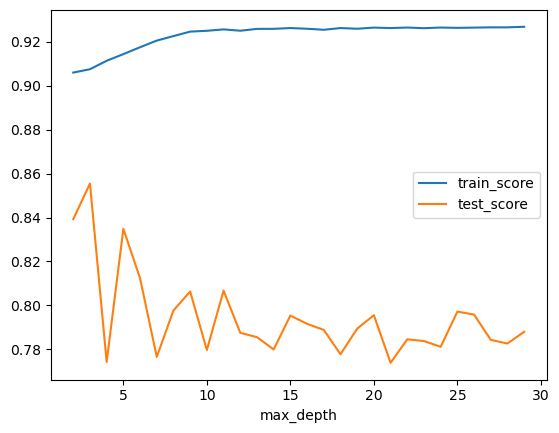

In [36]:
# Plot the results
models_df.plot()

In [37]:
# Try the following values for max_leaves
max_leaves = range(2, 30)
models = {'train_score': [], 'test_score': [], 'max_leaves': []}

# Loop through each value in max_depths
for leaf in max_leaves:
    # Initialize the classifier with parameter variables
    xgb_rus_clf = XGBClassifier(max_leaves = leaf, tree_method='approx', random_state=1)
    
    # Fit the undersampled data the new model
    xgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = xgb_rus_clf.predict(X_train_scaled)
    test_pred = xgb_rus_clf.predict(X_test_scaled)

    # Caclulate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_leaves'].append(leaf)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_leaves')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
max_leaves,,
2,0.904212,0.904258
3,0.904971,0.893685
4,0.905820,0.880484


In [38]:
# Sort the dataframe by test_score in descending order and get the top 3
top_max_leaves = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3
top_max_leaves

[2, 3, 4]

<Axes: xlabel='max_leaves'>

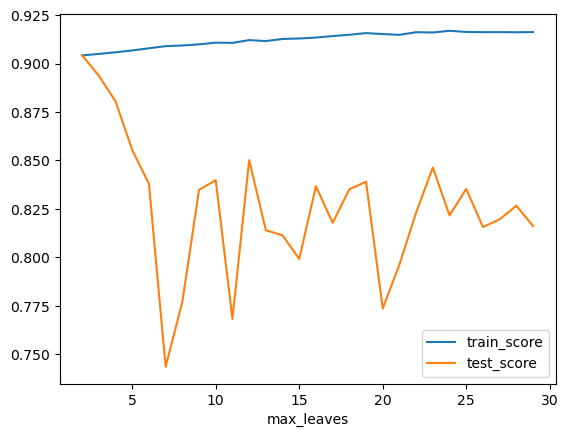

In [39]:
# Plot the results
models_df.plot()

In [40]:
# Try the following values for subsample
subsample = np.arange(0, 1, .01)
models = {'train_score': [], 'test_score': [], 'subsample': []}

# Loop through each value in max_depths
for sample in subsample:
    # Initialize the classifier with parameter variables
    xgb_rus_clf = XGBClassifier(subsample = sample, tree_method='approx', random_state=1)
    
    # Fit the undersampled data the new model
    xgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = xgb_rus_clf.predict(X_train_scaled)
    test_pred = xgb_rus_clf.predict(X_test_scaled)

    # Caclulate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['subsample'].append(sample)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('subsample')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
subsample,,
0.04,0.878331,0.923776
0.02,0.870274,0.921597
0.10,0.896033,0.919239


In [41]:
# Sort the dataframe by test_score in descending order and get the top 3
top_subsample = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3
top_subsample

[0.04, 0.02, 0.1]

<Axes: xlabel='subsample'>

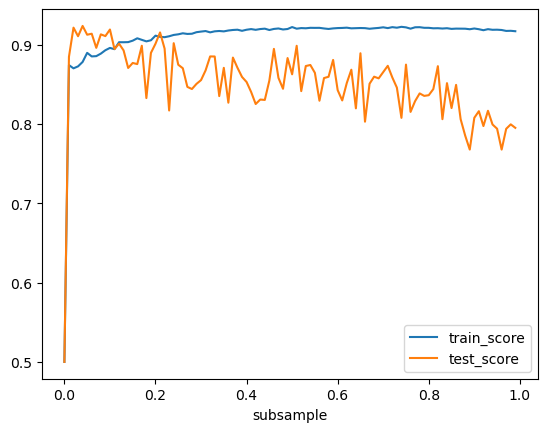

In [42]:
# Plot the results
models_df.plot()

In [43]:
# Dictionary with 3 values for each parameter
params = {
    'n_estimators': top_n_estimators,
    'max_depth': top_max_depth,
    'learning_rate': top_learning_rates,
    'max_leaves': top_max_leaves,
    'subsample': top_subsample
}

# Initialize a dictionary to store results
results = {'n_estimators': [], 'max_depth': [], 'learning_rate': [],'max_leaves': [], 'subsample': [], 'train_score': [], 'test_score': []}

# Loop through all combinations of parameters
for n in params['n_estimators']:
    for d in params['max_depth']:
        for lr in params['learning_rate']:
            for ml in params['max_leaves']:
                for s in params['subsample']:
                    # Initialize the classifier with current parameters
                    xgb_rus_clf = XGBClassifier(n_estimators=n, learning_rate=lr, max_depth=d, max_leaves=ml, subsample=s, tree_method='approx', random_state=1)
                
                    # Fit the undersampled data
                    xgb_rus_clf.fit(X_undersampled, y_undersampled)
    
                    # Make predictions
                    train_pred = xgb_rus_clf.predict(X_train_scaled)
                    test_pred = xgb_rus_clf.predict(X_test_scaled)
    
                    # Calculate balanced accuracy scores
                    train_score = balanced_accuracy_score(y_train, train_pred)
                    test_score = balanced_accuracy_score(y_test, test_pred)
    
                    # Append results to the dictionary
                    results['n_estimators'].append(n)
                    results['max_depth'].append(d)
                    results['learning_rate'].append(lr)
                    results['max_leaves'].append(ml)
                    results['subsample'].append(s)
                    results['train_score'].append(train_score)
                    results['test_score'].append(test_score)

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

In [44]:
sorted_results_df = results_df.sort_values(by='test_score', ascending=False)
print(sorted_results_df.head(3))

     n_estimators  max_depth  learning_rate  max_leaves  subsample  \
116           109          2           0.02           4        0.1   
197           105          2           0.02           4        0.1   
35            108          2           0.02           4        0.1   

     train_score  test_score  
116     0.902776    0.933747  
197     0.902776    0.933747  
35      0.902776    0.933747  


In [45]:
# For Classification
# Initialize the classifier with current parameters
xgb_rus_clf = XGBClassifier(n_estimators=162, max_depth=2, learning_rate=.03, max_leaves=3, subsample=.94, tree_method='approx', random_state=1)

# Fit the undersampled data
xgb_rus_clf.fit(X_undersampled, y_undersampled)

# Make predictions
train_pred = xgb_rus_clf.predict(X_train_scaled)
test_pred = xgb_rus_clf.predict(X_test_scaled)

# Generate classification report
# Print scores
print_balanced_accuracy_report(y_train, y_test, train_pred, test_pred)

# Print classification reports
print_classification_report(y_test, test_pred)

Balanced Accuracy Scores
--------------------------------------------------------
0.9044493183313225 training score
0.9334648999154215 testing score
-0.029015581584099 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      3547
           1       0.49      1.00      0.66       459

    accuracy                           0.88      4006
   macro avg       0.75      0.93      0.79      4006
weighted avg       0.94      0.88      0.90      4006

--------------------------------------------------------


## Original Scaled Data and Untuned LightBoost

In [46]:
# Define model
lgb_clf = lgb.LGBMClassifier(random_state=1, verbose=-1)

# Fit the model
lgb_clf.fit(X_train_scaled, y_train)

# Predict using the model
train_pred = lgb_clf.predict(X_train_scaled)
test_pred = lgb_clf.predict(X_test_scaled)

# Generate classification report
# Print scores
print_balanced_accuracy_report(y_train, y_test, train_pred, test_pred)

# Print classification reports
print_classification_report(y_test, test_pred)

Balanced Accuracy Scores
--------------------------------------------------------
0.836962976126268 training score
0.6812262103726308 testing score
0.1557367657536373 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3547
           1       0.56      0.40      0.47       459

    accuracy                           0.90      4006
   macro avg       0.74      0.68      0.71      4006
weighted avg       0.88      0.90      0.89      4006

--------------------------------------------------------


## Under Sampled Scaled Data with Untuned LightBoost

In [47]:
# Define model
lgb_rus_clf = lgb.LGBMClassifier(random_state=1, verbose=-1)

# Fit the model
lgb_rus_clf.fit(X_undersampled, y_undersampled)

# Predict using the model
train_pred = lgb_rus_clf.predict(X_train_scaled)
test_pred = lgb_rus_clf.predict(X_test_scaled)

# Generate classification report
# Print scores
print_balanced_accuracy_report(y_train, y_test, train_pred, test_pred)

# Print classification reports
print_classification_report(y_test, test_pred)

Balanced Accuracy Scores
--------------------------------------------------------
0.9122301825577203 training score
0.8923902675125747 testing score
0.0198399150451456 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.98      0.89      0.94      3547
           1       0.52      0.89      0.66       459

    accuracy                           0.89      4006
   macro avg       0.75      0.89      0.80      4006
weighted avg       0.93      0.89      0.90      4006

--------------------------------------------------------


## RandomUnderSampler Data with Tuned Lightboost Classifier

In [48]:
rates = np.arange(0.05, 1.0, 0.01)
models = {'train_score': [], 'test_score': [], 'learning_rate': []}

# Loop through each value in rates
for r in rates:
    # Initialize the classifier with current parameters
    lgb_rus_clf = lgb.LGBMClassifier(learning_rate=r, random_state=1, verbose=-1)

    # Fit the undersampled data
    lgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = lgb_rus_clf.predict(X_train_scaled)
    test_pred = lgb_rus_clf.predict(X_test_scaled)

    # Calculate balanced accuracy score
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['learning_rate'].append(r)

# Create a dataframe from the models dictionary with learning_rate as the index
models_df = pd.DataFrame(models).set_index('learning_rate')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
learning_rate,,
0.05,0.907512,0.917009
0.06,0.908769,0.915958
0.08,0.910833,0.909948


In [49]:
rates = np.arange(0.05, 1.0, 0.01)
models = {'train_score': [], 'test_score': [], 'learning_rate': []}

# Loop through each value in rates
for r in rates:
    # Initialize the classifier with current parameters
    lgb_rus_clf = lgb.LGBMClassifier(learning_rate=r, random_state=1, verbose=-1)

    # Fit the undersampled data
    lgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = lgb_rus_clf.predict(X_train_scaled)
    test_pred = lgb_rus_clf.predict(X_test_scaled)

    # Calculate balanced accuracy score
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['learning_rate'].append(r)

# Create a dataframe from the models dictionary with learning_rate as the index
models_df = pd.DataFrame(models).set_index('learning_rate')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
learning_rate,,
0.05,0.907512,0.917009
0.06,0.908769,0.915958
0.08,0.910833,0.909948


In [50]:
# Sort the dataframe by test_score in descending order and get the top 3
learning_rate = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3
learning_rate

[0.05, 0.060000000000000005, 0.08000000000000002]

<Axes: xlabel='learning_rate'>

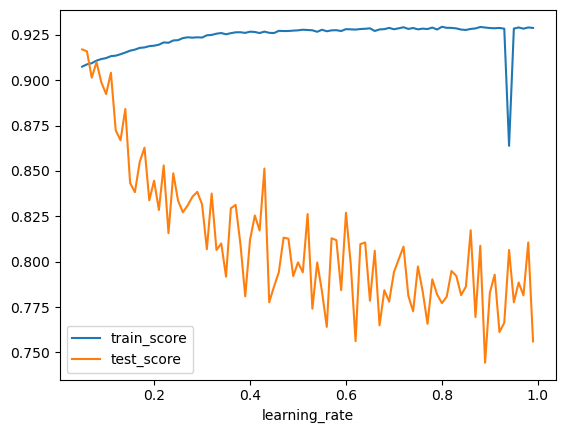

In [51]:
# Plot the results
models_df.plot()

In [52]:
# Try the following values for n_estimators
estimators = range(100, 250, 1)
models = {'train_score': [], 'test_score': [], 'n_estimators': []}

# Loop through each value in n_estimators
for n in estimators:
    # Initialize the classifier with current parameters
    lgb_rus_clf =lgb.LGBMClassifier(n_estimators = n, random_state=1, verbose=-1)

    # Fit the undersampled data
    lgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = lgb_rus_clf.predict(X_train_scaled)
    test_pred = lgb_rus_clf.predict(X_test_scaled)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['n_estimators'].append(n)

# Create a dataframe from the models dictionary with n_estimators as the index
models_df = pd.DataFrame(models).set_index('n_estimators')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
n_estimators,,
100,0.912230,0.89239
102,0.912259,0.89239
103,0.912375,0.89239


In [53]:
# Sort the dataframe by test_score in descending order and get the top 3
n_estimators = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3
n_estimators

[100, 102, 103]

<Axes: xlabel='n_estimators'>

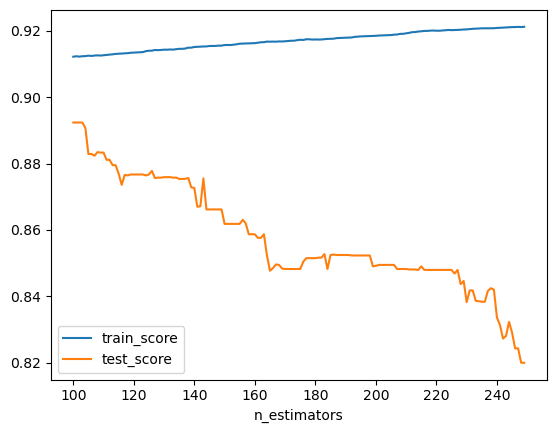

In [54]:
# Plot the results
models_df.plot()

In [55]:
# Try the following values for max_depth
max_depths = range(2, 30)
models = {'train_score': [], 'test_score': [], 'max_depth': []}

# Loop through each value in max_depths
for depth in max_depths:
    # Initialize the classifier with current parameters
    lgb_rus_clf = lgb.LGBMClassifier(max_depth = depth, random_state=1, verbose=-1)
    
    # Fit the undersampled data
    lgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = lgb_rus_clf.predict(X_train_scaled)
    test_pred = lgb_rus_clf.predict(X_test_scaled)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)
 
    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_depth'].append(depth)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_depth')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
max_depth,,
2,0.903848,0.925609
3,0.904908,0.925609
4,0.905488,0.923571


In [56]:
# Sort the dataframe by test_score in descending order and get the top 3
max_depth = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3 
max_depth

[2, 3, 4]

<Axes: xlabel='max_depth'>

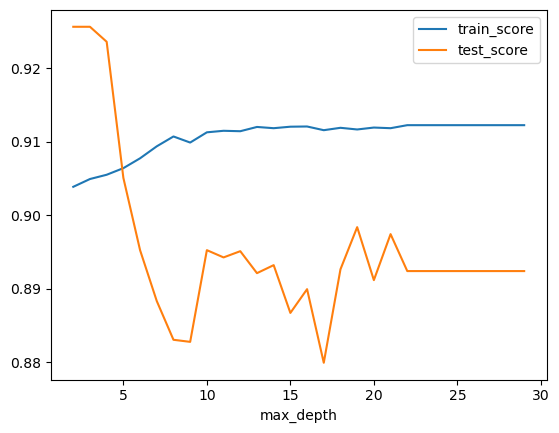

In [57]:
# Plot the results
models_df.plot()

In [58]:
# Try the following values for num_leaves
num_leaves = range(10, 50)
models = {'train_score': [], 'test_score': [], 'num_leaves': []}

# Loop through each value in num_leaves
for num in num_leaves:
    # Initialize the classifier with current parameters
    lgb_rus_clf = lgb.LGBMClassifier(num_leaves = num, random_state=1, verbose=-1)
    
    # Fit the undersampled data
    lgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = lgb_rus_clf.predict(X_train_scaled)
    test_pred = lgb_rus_clf.predict(X_test_scaled)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)
 
    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['num_leaves'].append(num)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('num_leaves')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
num_leaves,,
10,0.906851,0.925224
11,0.907470,0.918099
12,0.907349,0.914023


In [59]:
# Sort the dataframe by test_score in descending order and get the top 3
num_leaves = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3 
num_leaves

[10, 11, 12]

<Axes: xlabel='num_leaves'>

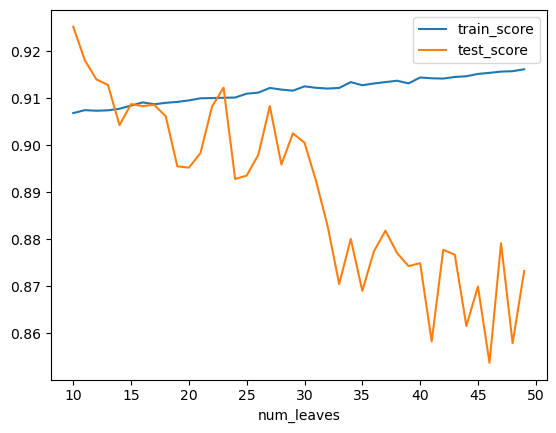

In [60]:
# Plot the results
models_df.plot()

In [61]:
# Try the following values for max_bin
max_bin = range(20, 512, 1)
models = {'train_score': [], 'test_score': [], 'max_bin': []}

# Loop through each value in max_bins
for bin in max_bin:
    # Initialize the classifier with current parameters
    lgb_rus_clf = lgb.LGBMClassifier(max_bin = bin, random_state=1, verbose=-1)
    
    # Fit the undersampled data
    lgb_rus_clf.fit(X_undersampled, y_undersampled)

    # Make predictions
    train_pred = lgb_rus_clf.predict(X_train_scaled)
    test_pred = lgb_rus_clf.predict(X_test_scaled)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)
 
    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_bin'].append(bin)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_bin')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(3))

,train_score,test_score
max_bin,,
22,0.907206,0.932170
86,0.910282,0.930940
80,0.909808,0.930722


In [62]:
# Sort the dataframe by test_score in descending order and get the top 3
max_bin = models_df.sort_values(by='test_score', ascending=False).head(3).index.tolist()

# Display the top 3 
max_bin

[22, 86, 80]

<Axes: xlabel='max_bin'>

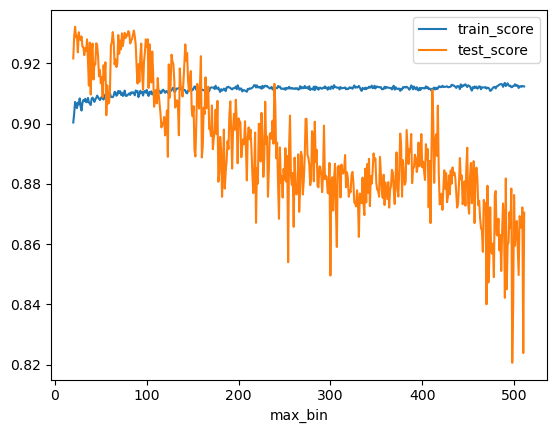

In [63]:
# Plot the results
models_df.plot()

In [64]:
# Dictionary with 3 values for each parameter
params = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'num_leaves': num_leaves,
    'max_bin': max_bin
}

# Initialize a dictionary to store results
results = {'n_estimators': [], 'max_depth': [], 'learning_rate': [], 'num_leaves': [], 'max_bin': [], 'train_score': [], 'test_score': []}

# Loop through all combinations of parameters
for n in params['n_estimators']:
    for d in params['max_depth']:
        for lr in params['learning_rate']:
            for nl in params['num_leaves']:
                for b in params['max_bin']:
                    # Initialize the classifier with current parameters
                    lgb_rus_clf = lgb.LGBMClassifier(n_estimators=n, learning_rate=lr, max_depth=d, num_leaves=nl, max_bin=b, random_state=1, verbose=-1)
                
                    # Fit the undersampled data
                    lgb_rus_clf.fit(X_undersampled, y_undersampled)
    
                    # Make predictions
                    train_pred = lgb_rus_clf.predict(X_train_scaled)
                    test_pred = lgb_rus_clf.predict(X_test_scaled)
    
                    # Calculate balanced accuracy scores
                    train_score = balanced_accuracy_score(y_train, train_pred)
                    test_score = balanced_accuracy_score(y_test, test_pred)
    
                    # Append results to the dictionary
                    results['n_estimators'].append(n)
                    results['max_depth'].append(d)
                    results['learning_rate'].append(lr)
                    results['num_leaves'].append(nl)
                    results['max_bin'].append(b)
                    results['train_score'].append(train_score)
                    results['test_score'].append(test_score)
                    
# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

In [65]:
sorted_results_df = results_df.sort_values(by='test_score', ascending=False)
print(sorted_results_df.head(3))

     n_estimators  max_depth  learning_rate  num_leaves  max_bin  train_score  \
157           102          4           0.08          11       86     0.902965   
154           102          4           0.08          10       86     0.902786   
235           103          4           0.08          10       86     0.902786   

     test_score  
157    0.933747  
154    0.933747  
235    0.933747  


In [66]:
# For Classification
# Initialize the classifier with current parameters
lgb_rus_clf = lgb.LGBMClassifier(n_estimators=102, max_depth=19, learning_rate=.07, num_leaves=26, max_bin=22, random_state=1, verbose=-1)

# Fit the undersampled data
lgb_rus_clf.fit(X_undersampled, y_undersampled)

# Make predictions
train_pred = lgb_rus_clf.predict(X_train_scaled)
test_pred = lgb_rus_clf.predict(X_test_scaled)

# Check the model's balanced accuracy on the training and test sets
# Print scores
print_balanced_accuracy_report(y_train, y_test, train_pred, test_pred, "RandomUnderSampled Data and Tuned LGB Classifer")

# Print classification reports
print_classification_report(y_test, test_pred)

RandomUnderSampled Data and Tuned LGB Classifer
--------------------------------------------------------
0.9049214826176826 training score
0.9332597494092709 testing score
-0.0283382667915884 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      3547
           1       0.50      1.00      0.67       459

    accuracy                           0.89      4006
   macro avg       0.75      0.93      0.80      4006
weighted avg       0.94      0.89      0.90      4006

--------------------------------------------------------


In [67]:
# Get the feature importance array
importances = lgb_rus_clf.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(lgb_rus_clf.feature_importances_, X.columns), reverse=True)
importances_sorted

[(569, 'RSI'),
 (513, 'MACD'),
 (482, 'SL'),
 (213, 'SMA200'),
 (188, 'SMA10'),
 (152, 'SMA100'),
 (146, 'BollL'),
 (109, 'SMA50'),
 (99, 'BollU'),
 (79, 'SMA20'),
 (0, 'SMA30'),
 (0, 'BollM')]